<a href="https://colab.research.google.com/github/KamilShape/emotion_recognition/blob/main/emotion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**

In [20]:
#Libraries
import os
import cv2
from google.colab.patches import cv2_imshow
import shutil
#----------------visualisation---------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
#----------------keras-----------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow import keras
#---------------PIL--------------------------
from PIL import Image

In [2]:
data_path = 'drive/MyDrive/faces/data'

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


*Dataset is quite balanced.*

# **2. Train and test set**

In [4]:
train_path = 'drive/MyDrive/recognized_faces/train'

In [5]:
test_path = 'drive/MyDrive/recognized_faces/test'

In [6]:
faces_path = 'drive/MyDrive/recognized_faces'

In [7]:
faces_folder = os.listdir('drive/MyDrive/recognized_faces')

In [8]:
faces = ['happiness', 'sadness', 'anger' ]

In [9]:
amount = []

for k in faces:
  amount.append(len(os.listdir(f'drive/MyDrive/recognized_faces/{k}')))

In [22]:
fig, ax = plt.subplots(figsize = (8,6))
colors = ['wheat', 'chocolate', 'lightskyblue']
ax.bar(faces, amount, color=colors, width=0.6)
ax.set_title('FACES')
ax.set_ylabel('Amount')

for i in range(0, len(faces)):
  ax.text(faces[i], amount[i] - 50, horizontalalignment='center', s=amount[i] )

ValueError: ignored

<Figure size 800x600 with 1 Axes>

In [11]:
def create_set(faces, path, new_path, set_size):
  for face in faces:
    files_folder = os.listdir(f'{path}/{face}')
    for n in range(0, round(len(files_folder)*set_size)):
      files_folder = os.listdir(f'{path}/{face}')
      photo_number = np.random.randint(len(files_folder))
      os.makedirs(f'{new_path}/{face}', exist_ok=True)
      os.replace(f'{path}/{face}/{files_folder[photo_number]}', f'{new_path}/{face}/{files_folder[photo_number]}')

In [ ]:
#creating train set
create_set(faces, faces_path, train_path, 0.8)

In [ ]:
#creating test set
create_set(faces, faces_path, test_path, 1)

In [12]:
img_height = 128
img_width = 128
batch_size = 100

In [19]:
train_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

val_ds = keras.utils.image_dataset_from_directory(
    train_path,
    validation_split = 0.2,
    seed=0,
    subset='validation',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

test_ds = keras.utils.image_dataset_from_directory(
    test_path,
    validation_split = 0.2,
    seed=0,
    subset='training',
    image_size = (img_height, img_width),
    batch_size = batch_size,
    label_mode = 'categorical')

Found 1441 files belonging to 3 classes.
Using 1153 files for training.
Found 1441 files belonging to 3 classes.
Using 288 files for validation.
Found 360 files belonging to 3 classes.
Using 288 files for training.


# **3. Model**

In [14]:
model = Sequential()
model.add(layers.Rescaling(1./255))

model.add(layers.Conv2D(128, (1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Conv2D(64, (1,1), padding='same', activation='relu'))
model.add(layers.MaxPool2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(3, activation='softmax'))

In [15]:
model.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

### **3.1 Test set**

In [23]:
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    batch_size = batch_size)

Epoch 1/30
12/12 [==============================] - 3s 138ms/step - loss: 0.1626 - accuracy: 0.9497 - val_loss: 0.9966 - val_accuracy: 0.6910
Epoch 2/30
12/12 [==============================] - 3s 136ms/step - loss: 0.1409 - accuracy: 0.9618 - val_loss: 1.0033 - val_accuracy: 0.6840
Epoch 3/30
12/12 [==============================] - 3s 139ms/step - loss: 0.1335 - accuracy: 0.9566 - val_loss: 1.0456 - val_accuracy: 0.6528
Epoch 4/30
12/12 [==============================] - 3s 138ms/step - loss: 0.1256 - accuracy: 0.9610 - val_loss: 0.9856 - val_accuracy: 0.6875
Epoch 5/30
12/12 [==============================] - 3s 136ms/step - loss: 0.1163 - accuracy: 0.9688 - val_loss: 1.0601 - val_accuracy: 0.6910
Epoch 6/30
12/12 [==============================] - 4s 232ms/step - loss: 0.1102 - accuracy: 0.9688 - val_loss: 1.1289 - val_accuracy: 0.6806
Epoch 7/30
12/12 [==============================] - 3s 139ms/step - loss: 0.1002 - accuracy: 0.9662 - val_loss: 1.1280 - val_accuracy: 0.6736
Epoch 

## **3.2 Test set**

In [25]:
history_test = model.fit(
    test_ds,
    validation_data = val_ds,
    epochs = 30,
    batch_size = batch_size)

Epoch 1/30
3/3 [==============================] - 70s 485ms/step - loss: 1.7402 - accuracy: 0.6458 - val_loss: 1.6524 - val_accuracy: 0.6424
Epoch 2/30
3/3 [==============================] - 1s 324ms/step - loss: 1.3788 - accuracy: 0.7014 - val_loss: 1.4491 - val_accuracy: 0.6250
Epoch 3/30
3/3 [==============================] - 1s 332ms/step - loss: 1.0105 - accuracy: 0.6806 - val_loss: 1.5110 - val_accuracy: 0.5938
Epoch 4/30
3/3 [==============================] - 1s 321ms/step - loss: 0.7442 - accuracy: 0.7465 - val_loss: 1.3829 - val_accuracy: 0.6111
Epoch 5/30
3/3 [==============================] - 1s 328ms/step - loss: 0.5786 - accuracy: 0.7708 - val_loss: 1.4190 - val_accuracy: 0.5972
Epoch 6/30
3/3 [==============================] - 2s 733ms/step - loss: 0.4435 - accuracy: 0.8368 - val_loss: 1.3891 - val_accuracy: 0.6111
Epoch 7/30
3/3 [==============================] - 2s 729ms/step - loss: 0.3738 - accuracy: 0.8507 - val_loss: 1.3619 - val_accuracy: 0.5938
Epoch 8/30
3/3 [===

# **4.Learning curves**

## **4.1 Train set**

In [34]:
train_loss = history.history['loss']
train_accuracy = history.history['accuracy']
val_loss = history.history['val_loss']
val_accuracy = history.history['val_accuracy']
array = np.arange(1,31,1)

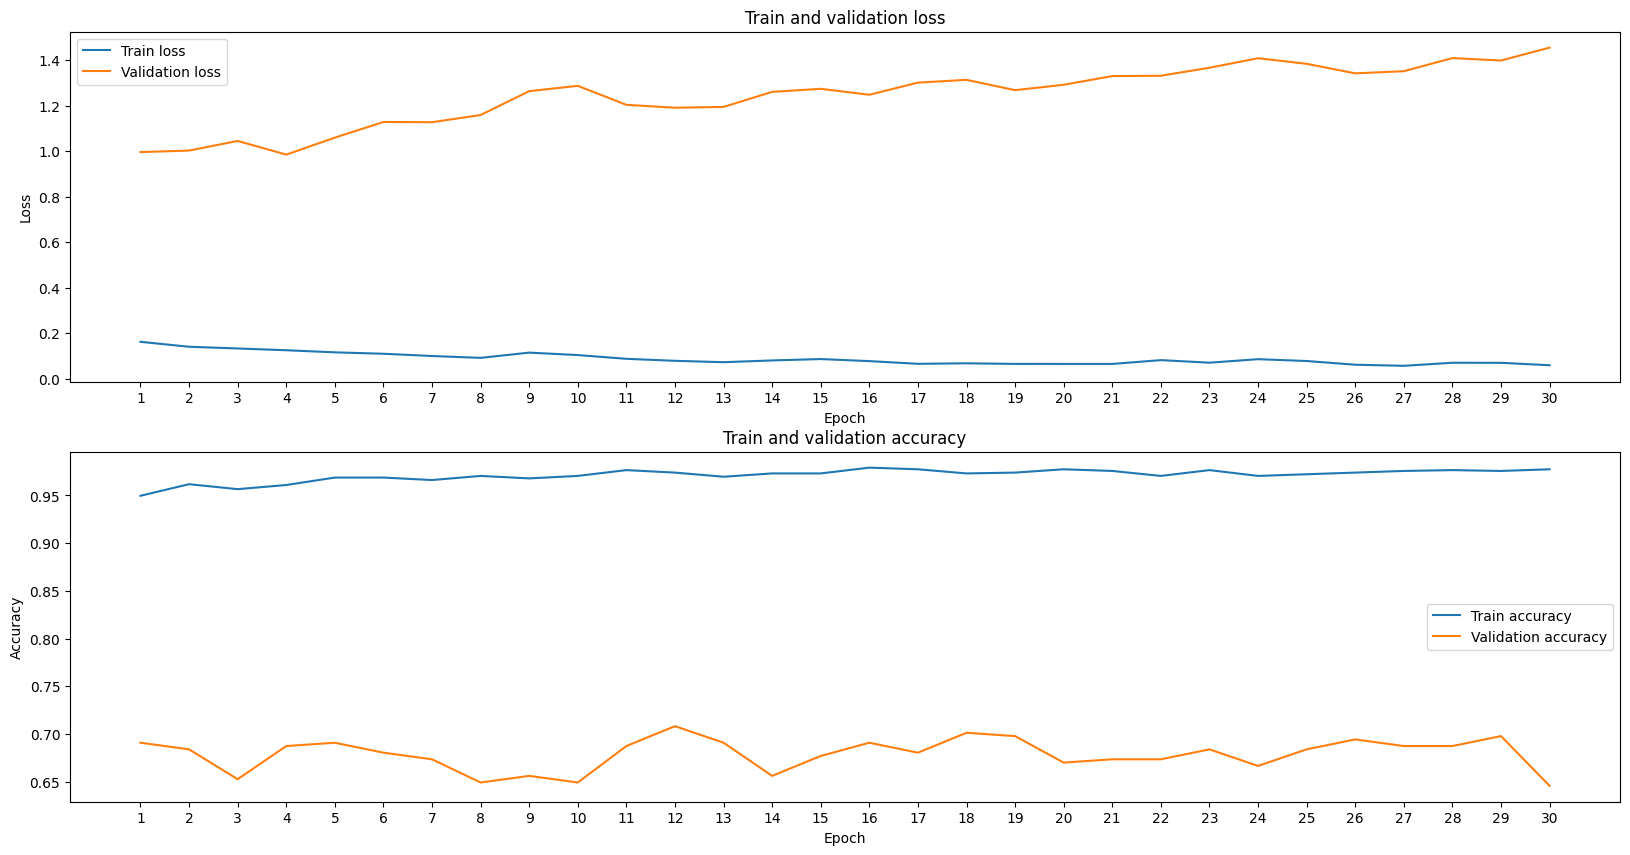

In [35]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax1.set_title('Train and validation loss')
ax1.plot(array, train_loss, label='Train loss')
ax1.plot(array, val_loss, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(array, train_accuracy, label='Train accuracy')
ax2.plot(array, val_accuracy, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
ax1.set_xticks(array)
ax2.set_xticks(array)

## **4.2 Test set**

In [36]:
test_loss = history_test.history['loss']
test_accuracy = history_test.history['accuracy']
test_val_loss = history_test.history['val_loss']
test_val_accuracy = history_test.history['val_accuracy']
array = np.arange(1,31,1)

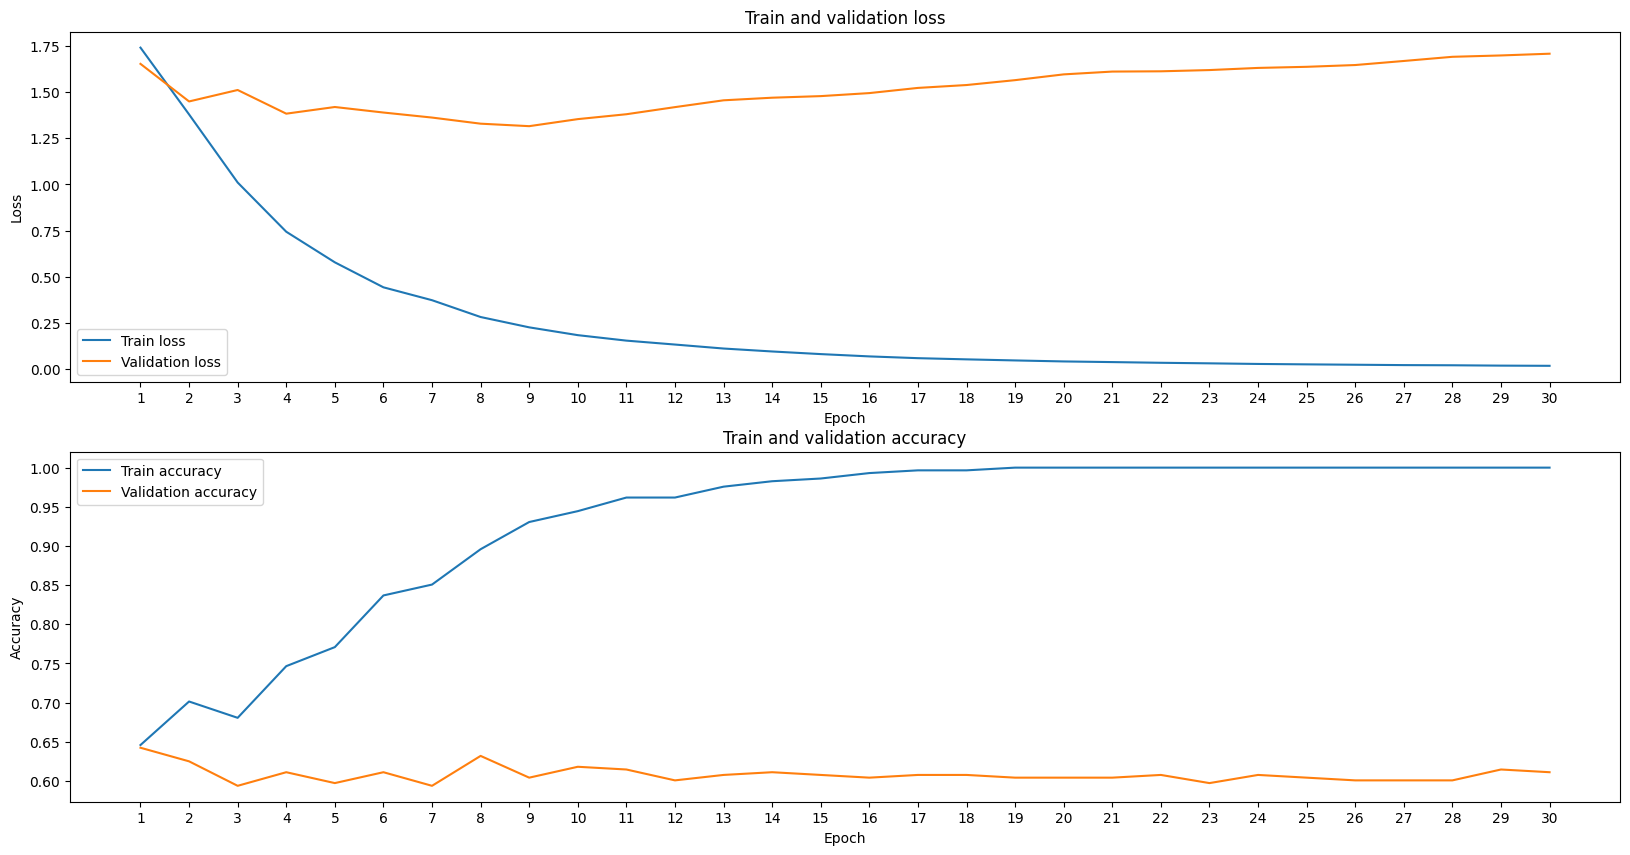

In [37]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax1.set_title('Train and validation loss')
ax1.plot(array, test_loss, label='Train loss')
ax1.plot(array, test_val_loss, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(array, test_accuracy, label='Train accuracy')
ax2.plot(array, test_val_accuracy, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
ax1.set_xticks(array)
ax2.set_xticks(array)

# **5. Neural network with augumentation and dropout**

In [28]:
model2 = Sequential()
model2.add(layers.Rescaling(1./255))

model2.add(layers.Conv2D(64, (1,1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Rescaling(scale=4, offset=0.0))

model2.add(layers.Conv2D(32, (1,1), padding='same', activation='relu'))
model2.add(layers.MaxPool2D((2,2)))
model2.add(layers.Dropout(rate=0.1))

model2.add(layers.Flatten())
model2.add(layers.Dense(3, activation='softmax'))

In [29]:
model2.compile(optimizer='Adam',
              loss='categorical_crossentropy',
              metrics = ['accuracy'])

In [30]:
history2 = model2.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 30,
    batch_size = batch_size)

Epoch 1/30
12/12 [==============================] - 5s 151ms/step - loss: 2.9990 - accuracy: 0.3712 - val_loss: 1.0444 - val_accuracy: 0.5000
Epoch 2/30
12/12 [==============================] - 2s 124ms/step - loss: 1.4222 - accuracy: 0.3929 - val_loss: 1.0571 - val_accuracy: 0.4375
Epoch 3/30
12/12 [==============================] - 3s 128ms/step - loss: 1.1196 - accuracy: 0.4050 - val_loss: 1.0564 - val_accuracy: 0.4167
Epoch 4/30
12/12 [==============================] - 3s 149ms/step - loss: 1.0136 - accuracy: 0.4675 - val_loss: 0.9846 - val_accuracy: 0.5347
Epoch 5/30
12/12 [==============================] - 2s 122ms/step - loss: 0.9072 - accuracy: 0.5768 - val_loss: 0.9411 - val_accuracy: 0.5660
Epoch 6/30
12/12 [==============================] - 3s 120ms/step - loss: 0.8129 - accuracy: 0.6392 - val_loss: 0.9269 - val_accuracy: 0.6007
Epoch 7/30
12/12 [==============================] - 2s 119ms/step - loss: 0.7221 - accuracy: 0.6895 - val_loss: 0.8824 - val_accuracy: 0.6007
Epoch 

# **6. Learning curve - dropout and augumentation**

In [31]:
train_loss2 = history2.history['loss']
train_accuracy2 = history2.history['accuracy']
val_loss2 = history2.history['val_loss']
val_accuracy2 = history2.history['val_accuracy']
array2 = np.arange(1,31,1)

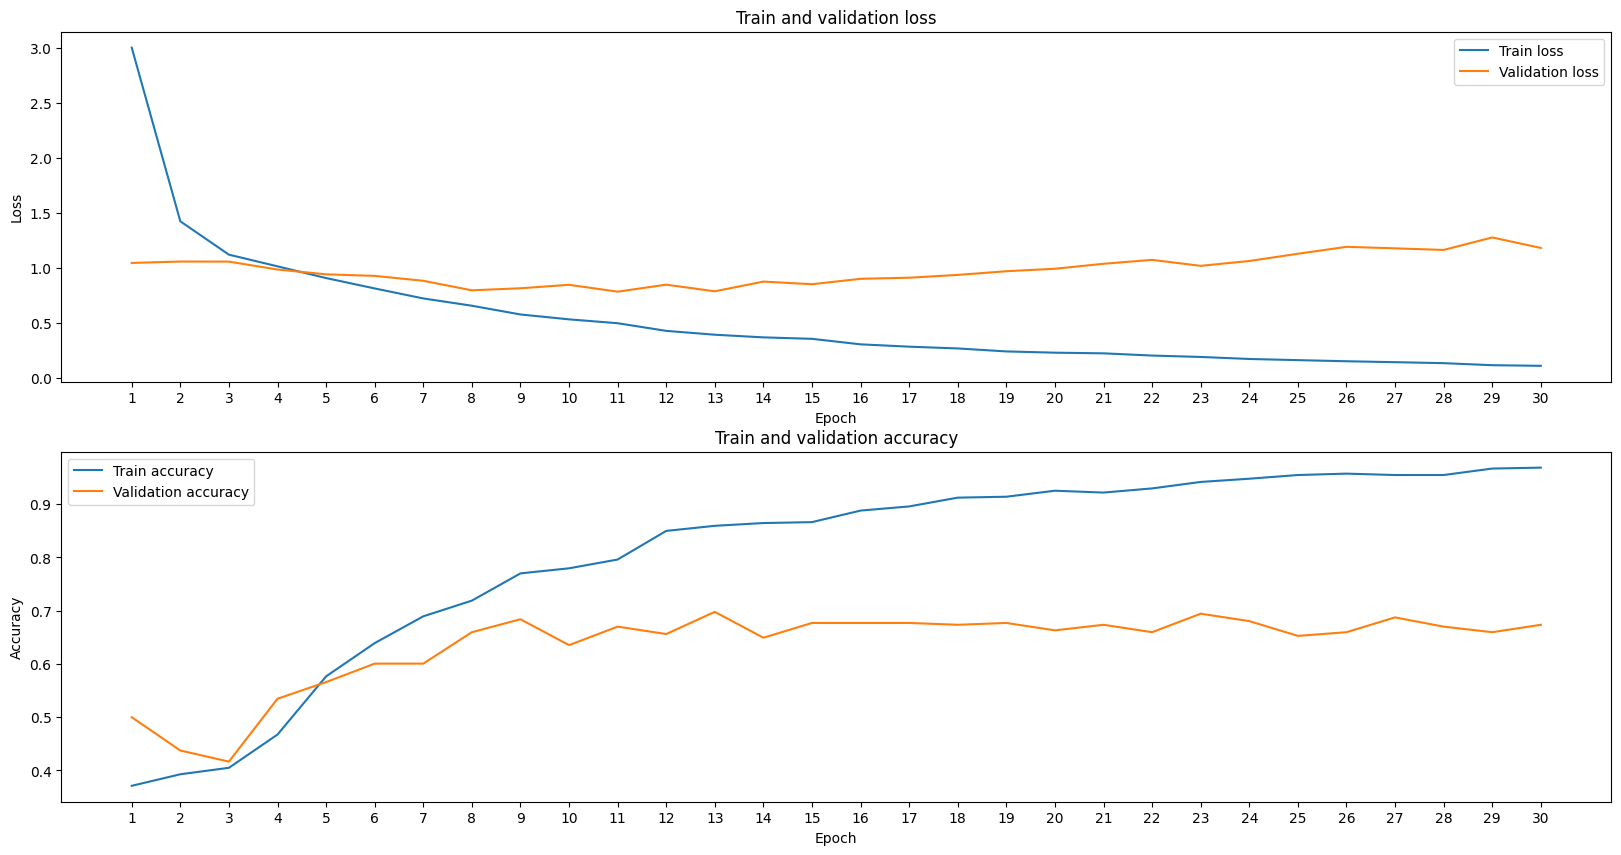

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (20,10))
ax1.set_title('Train and validation loss')
ax1.plot(array2, train_loss2, label='Train loss')
ax1.plot(array2, val_loss2, label = 'Validation loss')
ax2.set_title('Train and validation accuracy')
ax2.plot(array2, train_accuracy2, label='Train accuracy')
ax2.plot(array2, val_accuracy2, label = 'Validation accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax1.legend()
ax2.legend()
ax1.set_xticks(array2)
ax2.set_xticks(array2)

# **7. Conclusions**

Looking at results from two models we can see no big difference between model with and without augumentation. Quite probably there might be affected by bad quality of photos or not enough photos in dataset.